# PyTropD Xarray Tutorial

Try it out! [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/tropd/pytropd/master?labpath=pytropd%2Fxr_tutorial.ipynb)

This tutorial walks through how to use PyTropD's [xarray](https://docs.xarray.dev/en/stable/index.html "Xarray Docs") interface. Very little experience with xarray is assumed, but, if more practice is desired, there are some helpful tutorials [here](https://tutorial.xarray.dev/intro.html).

## Basic Usage

Starting with NetCDF data, Grib data, or one of the [many other file formats supported by xarray](https://docs.xarray.dev/en/stable/user-guide/io.html), computing metrics using PyTropD has a simple workflow:

1. Open the data with [`open_dataset`](https://docs.xarray.dev/en/stable/generated/xarray.open_dataset.html)
2. Ensure the variable has a name discoverable by PyTropD (see [table](#xarray-variable-naming-conventions) below) if more than one variable is in the dataset
3. Compute the desired metric using the `pyt_metrics` accessor
4. (Optional) Plot or save the output

### Xarray Variable Naming Conventions
| Variable                        | Metrics             | PyTropD name variations [case, whitespace, and delimiter (-,_) insensitive] |
|---------------------------------|---------------------|-----------------------------------------------------------------------------|
| latitude                        | all                 | lat, latitude, lats, x, phi, degreesnorth                                   |
| pressure                        | EDJ/PSI/STJ/TPB/UAS | pres, pressure, p, lev, levels, level                                       |
| zonal wind                      | EDJ/STJ/UAS         | zonalwind, uwind, u, xwind                                                  |
| meridional wind                 | PSI                 | meridionalwind, vwind, v, ywind                                             |
| surface wind                    | UAS                 | surfacewind, uas, us, surfu, usurf                                          |
| temperature                     | TPB                 | t, temp, temperature                                                        |
| sea-level pressure              | PSL                 | sealevelpressure, slp, psl, ps, sp                                          |
| outgoing longwave radiation     | OLR                 | olr, outgoinglongwaveradiation, toaolr, olrtoa                              |
| precipitation minus evaporation | PE                  | pe, precipitationminusevarporation, pminuse                                 |
| geopotential height             | TPB                 | z, h, height, geopotentialheight                                            |

Note: Names are case, whitespace, and delimiter (-,_) insensitive, so names like "p-minus-e", "P_MINUS_E", and "P minus E" are all equivalent.

In [1]:
# first we'll import. Even though we don't use pytropd directly, it must be imported to use the pyt_metrics accessor
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pytropd as pyt
from pathlib import Path
import matplotlib.ticker as mtick
from pandas import date_range
from matplotlib import rcParams
from scipy.stats import linregress
from itertools import combinations
from cycler import cycler

# directory where some toy ERA-Interim data is stored
data_dir = Path(pyt.__file__).parent.parent / "ValidationData"

#set dpi/style
plt.style.use('ggplot')
rcParams.update({'figure.dpi':100.0})

# formatter for nice latitude labels
@mtick.FuncFormatter
def latitude_formatter(x, pos):
    return f"{abs(x):g}\u00b0{'N' if x > 0 else 'S'}"

# xarray can do sophisticated timeseries processing using pandas 
# if time information is properly encoded - but it isn't for these toy files, so 
# we'll need to add it back in
def add_times(ds):
    return ds.assign_coords(
        time=date_range(start="1979-01-01", periods=ds.time.size, freq="MS")
    )

/N/slate/samjsmit/miniconda3/envs/tropd/lib/python3.7/site-packages/pygeode/plot/wrappers.py:590: UserWarning: Neither Cartopy nor Basemap functionality is available.
  warnings.warn('Neither Cartopy nor Basemap functionality is available.')


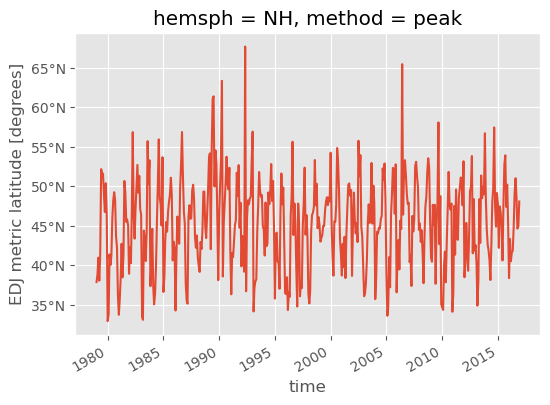

In [2]:
# 1. we'll load some netCDF data
u_data = xr.open_dataset(data_dir/"ua.nc")
# 2. we'll make sure the time axis is properly defined
u_data = add_times(u_data)
# 3. compute!
edj_lats = u_data.pyt_metrics.xr_edj()
# 4. plot!
edj_lats.sel(hemsph="NH").plot()
plt.gca().yaxis.set_major_formatter(latitude_formatter)

The `xarray` interface for `pytropd` returns a `DataArray` with two added dimensions, and vertical and north-south dimensions are removed. 

The first added dimension we've already seen, it is called `hemsph` and contains the metric latitudes for Northern ("NH") and Southern ("SH") hemispheres separately. If only one hemisphere of data is provided, only one hemisphere is returned.

The other added dimension is `method`, detailing the method used in determining the latitude for that metric.

In [3]:
edj_lats.method

<xarray.DataArray 'method' (method: 1)>
array(['peak'], dtype='<U4')
Coordinates:
  * method   (method) <U4 'peak'
Attributes:
    long_name:    method used
    units:        
    description:  Latitude of the maximum of the zonal wind at the level clos...

This dimension can be aggregated over to compare methods, as in the next example.

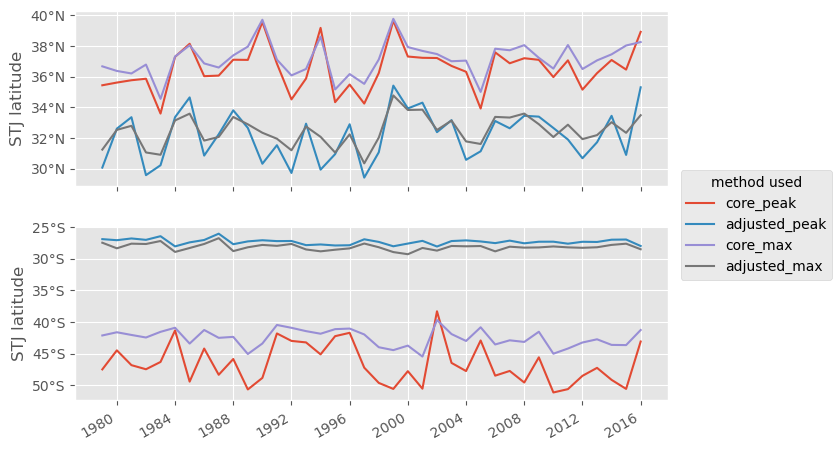

In [5]:
# convert monthly to annual
u_annual = u_data.resample(time='AS').mean()
# iterate over methods
methods = ["core_peak", "adjusted_peak", "core_max", "adjusted_max"]
stj_lats = xr.concat(
    [u_annual.pyt_metrics.xr_stj(method=m) for m in methods], dim="method"
)
# rearrange so northern hemisphere is plotted first
stj_lats = stj_lats.sortby("hemsph")
# here we make use of xarray's FaceGrid interface (row keyword)
grid = stj_lats.plot(hue="method", row="hemsph", sharey=False, figsize=(7,5))
grid.set_xlabels("")
grid.set_ylabels("STJ latitude")
grid.set_titles("")
for ax in grid.axs.flatten():
    ax.yaxis.set_major_formatter(latitude_formatter)

For the final examples, we put together some of the capabilities of xarray and pytropd to demonstrate how they can work together in more advanced use cases.

In [16]:
help(xr.Dataset().pyt_metrics.xr_tpb)

Help on method xr_tpb in module pytropd.xarray_metrics:

xr_tpb(**params) -> xarray.core.dataarray.DataArray method of pytropd.xarray_metrics.MetricAccessor instance
    TropD Tropopause Break (TPB) Metric
    
    Finds the latitude of the tropopause break
    
    The :py:class:`Dataset` should contain one variable corresponding to temperature.
    If multiple non-coordinate variables are in the dataset, this method attempts to
    guess which field corresponds to temperature based on field's name. The
    :py:class:`Dataset` should also contain a latitude-like dimension and a
    pressure-like dimension. If using ``method="cutoff"``, there should be an
    additional variable in the :py:class:`Dataset` corresponding to geopotential
    height in meters
    
    Parameters
    ----------
    method : {"max_gradient", "cutoff", "max_potemp"}, optional
        Method to identify tropopause break, by default "max_gradient":
    
        * "max_gradient": The latitude of maximal poleward

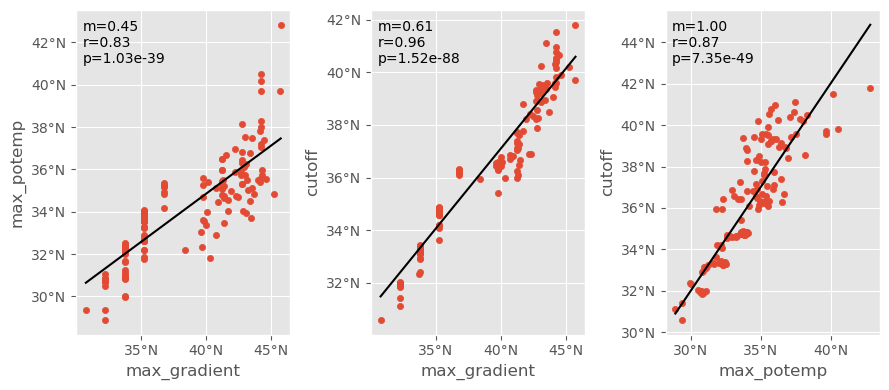

In [6]:
# open data
t_data = add_times(xr.open_dataset(data_dir/"ta.nc"))
z_data = add_times(xr.open_dataset(data_dir/"zg.nc"))
tz_data = xr.Dataset({"t":t_data.ta, "z":z_data.zg})
# this time we'll look at seasonal relationships in the NH
tz_seasonal = tz_data.resample(time="QS-DEC").mean()
tz_NH = tz_seasonal.sortby('lat').sel(lat=slice(0,None))
tpb_lats_mg = tz_NH.pyt_metrics.xr_tpb(method="max_gradient")
tpb_lats_mp = tz_NH.pyt_metrics.xr_tpb(method="max_potemp")
tpb_lats_co = tz_NH.pyt_metrics.xr_tpb(method="cutoff")

# plot using normal matplotlib
fig, axes = plt.subplots(1,3, figsize=(9,4))
for ax,(x,y) in zip(axes,combinations([tpb_lats_mg, tpb_lats_mp, tpb_lats_co],2)):
    stats = linregress(x.squeeze(),y.squeeze())
    x_coord = np.linspace(x.min(), x.max(),101)
    trend = x_coord*stats.slope+stats.intercept
    ax.scatter(x,y,s=20)
    ax.plot(x_coord, trend, c='k')
    ax.yaxis.set_major_formatter(latitude_formatter)
    ax.xaxis.set_major_formatter(latitude_formatter)
    ax.set_xlabel(x.method.values[0])
    ax.set_ylabel(y.method.values[0])
    ax.text(
        .03,
        .97,
        f"m={stats.slope:.2f}\nr={stats.rvalue:.2f}\np={stats.pvalue:.2e}",
        transform=ax.transAxes,
        ha='left',
        va='top',
    )
plt.tight_layout()

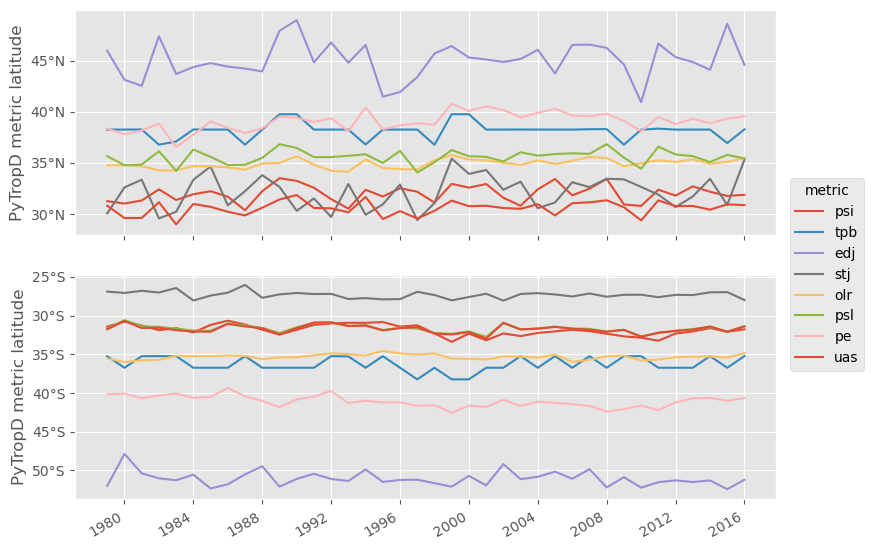

In [7]:
# load all the data for all metrics, except ones we aren't using
combined_data = add_times(xr.open_mfdataset(
    [f for f in data_dir.glob("*.nc") if f.stem not in ["XN2O", "zg", "rlntcs"]]
))
# clean up names
combined_data = combined_data.rename(ta="t", ua="u", va="v", rlnt="olr")
# fix signs, compute P-E, ditch extra vars
combined_data["olr"] *= -1.0
combined_data["pe"] = combined_data.pr + combined_data.hfls / 2510400.0
combined_data = combined_data.drop_vars(["hfls", "pr"])
# resample and load (open_mfdataset utitlizes dask, which
# pytropd doesn't fully support - yet)
annual_data = combined_data.resample(time="AS").mean()
annual_data.load()

# compute metrics
metrics = ["psi", "tpb", "edj", "stj", "olr", "psl", "pe", "uas"]
all_metrics = xr.merge(
    [getattr(annual_data.pyt_metrics, f"xr_{mtc}")().squeeze().drop("method")
    for mtc in metrics]
)
# rearrange so northern hemisphere is plotted first
all_metrics = all_metrics.sortby("hemsph")
# we'll stack all the variables into a new metric dimension and plot using FacetGrid again
grid = all_metrics.to_array("metric").plot(
    hue="metric", row="hemsph", sharey=False, figsize=(8,6)
)
grid.set_xlabels("")
grid.set_ylabels("PyTropD metric latitude")
grid.set_titles("")
for ax in grid.axs.flatten():
    ax.yaxis.set_major_formatter(latitude_formatter)